In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Reflect an existing database into a new model
conn = engine.connect()

# Reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [ ]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

In [10]:
# Create inspector and connect to engine
inspector = inspect(engine)

# Use inspector to print column names and variable types within the measurement table
columns = inspector.get_columns("measurement")

print("Measurement:")
print("")
for column in columns:
    print(column["name"], column["type"])
print("")  

# Use inspector to print column names and variable types within the station table
columns = inspector.get_columns("station")

print("Station:")
print("")
for column in columns:
    print(column["name"], column["type"])

Measurement:

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Station:

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


### Precipitation Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Check earliest and latest dates in dataset and convert to datetime objects
earliest_date = session.query(Measurement.date).order_by(Measurement.date).first()
earliest_date_obj = dt.datetime.strptime(earliest_date[0], "%Y-%m-%d")
print(f"Earliest date: {earliest_date_obj}")

latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date_obj = dt.datetime.strptime(latest_date[0], "%Y-%m-%d")
print(f"Latest date: {latest_date_obj}")

# Calculate the date 1 year ago from the last data point in the database
year_ago = latest_date_obj - dt.timedelta(days=365)
print(f"Year ago: {year_ago}")


Earliest date: 2010-01-01 00:00:00
Latest date: 2017-08-23 00:00:00
Year ago: 2016-08-23 00:00:00


In [12]:
# Perform a query to retrieve the data and precipitation scores
sel = (Measurement.date, Measurement.prcp)
precipitation = session.query(*sel).\
    filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame, set the index to the date column, and sort by date
precipitation_df = pd.DataFrame(precipitation)
precipitation_df = precipitation_df.set_index("date")
precipitation_df = precipitation_df.sort_index()
precipitation_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


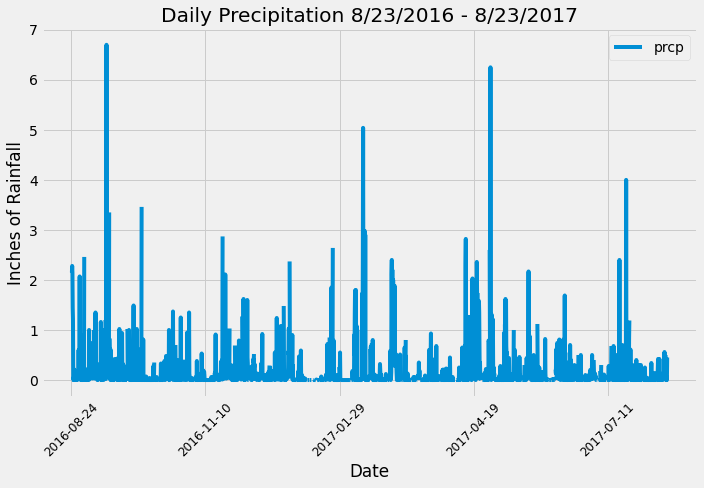

In [13]:
# Plot the temperature data
precipitation_df.plot(figsize=(10,7))
plt.xticks(rotation=45, fontsize=12)
plt.title("Daily Precipitation 8/23/2016 - 8/23/2017")
plt.xlabel("Date")
plt.ylabel("Inches of Rainfall")
plt.tight_layout()
plt.savefig("Images/Daily Precipitation.png", bbox_inches="tight")
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [15]:
# Design a query to show how many stations are available in this dataset
num_stations = session.query(distinct(Measurement.station)).count()
print(f"There are {num_stations} stations")

There are 9 stations


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

sel = (Measurement.station, func.count(Measurement.station))
measurement_count_by_station = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

measurement_count_by_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Determine the most active station
most_active = measurement_count_by_station[0][0]
print(f"The most active stations is {most_active}.")

The most active stations is USC00519281.


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

sel = (Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))
temp_stats = session.query(*sel).filter_by(station=most_active).all()
print(f"The lowest temperature recorded was {temp_stats[0][1]} degrees Fahrenheit")
print(f"The highest temperature recorded was {temp_stats[0][2]} degrees Fahreneheit")
print(f"The average recorded temperature was {round(temp_stats[0][3], 1)} degrees Fahrenheit")

The lowest temperature recorded was 54.0 degrees Fahrenheit
The highest temperature recorded was 85.0 degrees Fahreneheit
The average recorded temperature was 71.7 degrees Fahrenheit


In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station

sel = (Measurement.station, Measurement.date, Measurement.tobs)
temp = session.query(*sel).filter_by(station=most_active).filter(Measurement.date>=year_ago).all()
temp_df = pd.DataFrame(temp)
temp_df.head()

,station,date,tobs
0,USC00519281,2016-08-24,77.0
1,USC00519281,2016-08-25,80.0
2,USC00519281,2016-08-26,80.0
3,USC00519281,2016-08-27,75.0
4,USC00519281,2016-08-28,73.0


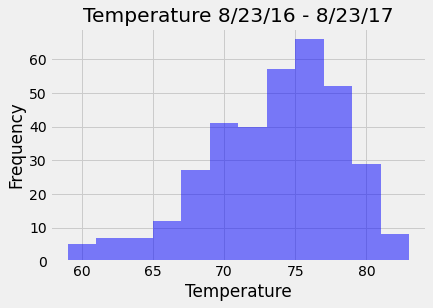

In [20]:
# Plot the results as a histogram
num_bins = 12
n, bins, patches = plt.hist(temp_df["tobs"], num_bins, facecolor="blue", alpha=0.5)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature 8/23/16 - 8/23/17")
plt.savefig("Images/Temperature Histogram.png", bbox_inches="tight")
plt.show()

## Bonus Challenge Assignment

### Temperature Analysis 1

In [21]:
# Perform querty to retrieve temperature data for month of June
date_str = "06"
june_temp = session.query(*sel).filter(func.strftime("%m", Measurement.date) == date_str).all()

# Convert to Pandas DataFrame
june_temp_df = pd.DataFrame(june_temp)
june_temp_df

,station,date,tobs
0,USC00519397,2010-06-01,78.0
1,USC00519397,2010-06-02,76.0
2,USC00519397,2010-06-03,78.0
3,USC00519397,2010-06-04,76.0
4,USC00519397,2010-06-05,77.0
...,...,...,...
1695,USC00516128,2017-06-26,79.0
1696,USC00516128,2017-06-27,74.0
1697,USC00516128,2017-06-28,74.0
1698,USC00516128,2017-06-29,76.0


In [22]:
# Perform querty to retrieve temperature data for month of December
date_str = "12"
dec_temp = session.query(*sel).filter(func.strftime("%m", Measurement.date) == date_str).all()

# Convert to Pandas DataFrame
dec_temp_df = pd.DataFrame(dec_temp)
dec_temp_df

,station,date,tobs
0,USC00519397,2010-12-01,76.0
1,USC00519397,2010-12-03,74.0
2,USC00519397,2010-12-04,74.0
3,USC00519397,2010-12-06,64.0
4,USC00519397,2010-12-07,64.0
...,...,...,...
1512,USC00516128,2016-12-27,71.0
1513,USC00516128,2016-12-28,71.0
1514,USC00516128,2016-12-29,69.0
1515,USC00516128,2016-12-30,65.0


In [23]:
# Calculate average temp in June and December
avg_june_temp = june_temp_df["tobs"].mean()
avg_dec_temp = dec_temp_df["tobs"].mean()

print(f"The average temperature in June is {round(avg_june_temp, 1)}")
print(f"The average temperature in December is {round(avg_dec_temp, 1)}")

The average temperature in June is 74.9
The average temperature in December is 71.0


In [24]:
# Perform unpaired t test to determine if difference in means is statistically significant
# Low p value (<0.5) indicates a statistically significant difference in the means
stats.ttest_ind(june_temp_df["tobs"], dec_temp_df["tobs"], equal_var=False)

Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

### Temperature Analysis II

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start = "2017-05-01"
end = "2017-05-14"

temp_stats = calc_temps(start, end)
temp_stats

tmin = temp_stats[0][0]
tavg = temp_stats[0][1]
tmax = temp_stats[0][2]

print(f"The minimum temperature was {tmin}")
print(f"The average temperature was {round(tavg, 1)}")
print(f"The maximum temperature was {tmax}")

The minimum temperature was 65.0
The average temperature was 75.2
The maximum temperature was 80.0


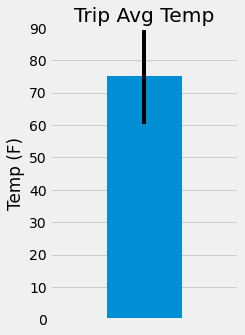

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

upper_error = tmax
lower_error = tmin
error_range = tmax - tmin

x_axis = 1
plt.figure(figsize=(3,5))
plt.bar(x_axis, tavg, yerr=error_range, width=0.8, align="center")
plt.ylim(0, 90)
plt.xlim(0, 2)
plt.xticks([])
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp")
plt.tight_layout
plt.savefig("Images/Trip Avg Temp.png")
plt.show()

### Daily Rainfall Average

In [29]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start = "2017-05-01"
end = "2017-05-14"

sel = (Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp))
station_rainfall = session.query(*sel).filter(Station.station == Measurement.station).\
    filter(Measurement.date >= start).filter(Measurement.date <= end).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()
station_rainfall

# Convert to Pandas DataFrame
station_rainfall_df = pd.DataFrame(station_rainfall, columns = ["station", "name", "latitude", "longitude", "elevation", "total prcp"])
station_rainfall_df

,station,name,latitude,longitude,elevation,total prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,3.91
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,3.11
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2.21
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.94
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.81
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.27


In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [31]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start = dt.datetime(2017, 5, 1)
end = dt.datetime(2017, 5, 14)

# Use the start and end date to create a range of dates
date = start
date_list = []
while date <= end:
    date_list.append(date)
    date += dt.timedelta(days=1)

# Stip off the year and save a list of %m-%d strings

yearless_date_list = []
for date in date_list:
    new_date = dt.date.strftime(date, "%m-%d")
    yearless_date_list.append(new_date)   

# Loop through the list of %m-%d strings and calculate the normals for each date
normals_list = []
for date in yearless_date_list:
    normal = daily_normals(date)
    normals_list.append(normal[0])
normals_list

[(65.0, 72.75925925925925, 79.0),
 (65.0, 73.05084745762711, 79.0),
 (67.0, 73.41071428571429, 84.0),
 (65.0, 73.59649122807018, 78.0),
 (67.0, 73.39655172413794, 79.0),
 (66.0, 73.14035087719299, 80.0),
 (64.0, 71.78846153846153, 79.0),
 (65.0, 72.18867924528301, 80.0),
 (67.0, 72.9322033898305, 79.0),
 (64.0, 73.3157894736842, 78.0),
 (65.0, 73.61111111111111, 79.0),
 (65.0, 73.13793103448276, 79.0),
 (67.0, 73.14285714285714, 79.0),
 (63.0, 73.89285714285714, 80.0)]

In [32]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals_list, index=yearless_date_list, columns = ["tmin", "tavg", "tmax"])
normals_df

,tmin,tavg,tmax
05-01,65.0,72.759259,79.0
05-02,65.0,73.050847,79.0
05-03,67.0,73.410714,84.0
05-04,65.0,73.596491,78.0
05-05,67.0,73.396552,79.0
05-06,66.0,73.140351,80.0
05-07,64.0,71.788462,79.0
05-08,65.0,72.188679,80.0
05-09,67.0,72.932203,79.0
05-10,64.0,73.315789,78.0


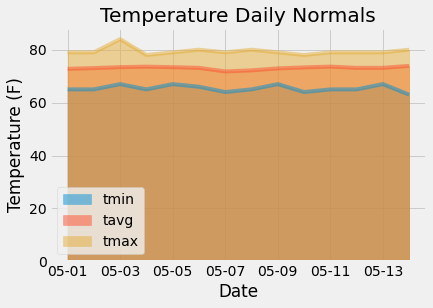

In [36]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False)
plt.title("Temperature Daily Normals")
plt.xlabel("Date")
plt.ylabel("Temperature (F)")
plt.tight_layout
plt.savefig("Images/Temperature Daily Normals.png")
plt.show()